#**1. HomeWork Introduction**

과제는 다음과 같습니다.

1. 이미지 최종 embedding size 맞도록 계산 및 코드 수정하기
2. 좋은 성능이 나오도록 자유롭게 Resnet Fine tunning 실험해보기

##1. Image Size 수정

앞선 수업코드에서는 ResNet 본래의 input size인 224를 맞추기 위해 Resize와 Crop을 사용하였습니다.

그러나 resize와 crop을 거친 이미지는 원본의 특징을 정확하게 반영하지 못할 가능성이 있습니다. 

따라서 아래의 식을 이용해 ResNet18이 우리의 input image size를 받고도 작동하도록 모델을 바꿔주세요

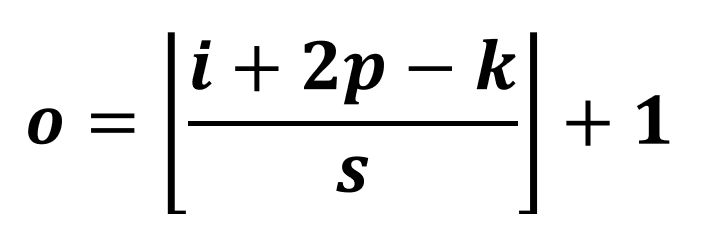

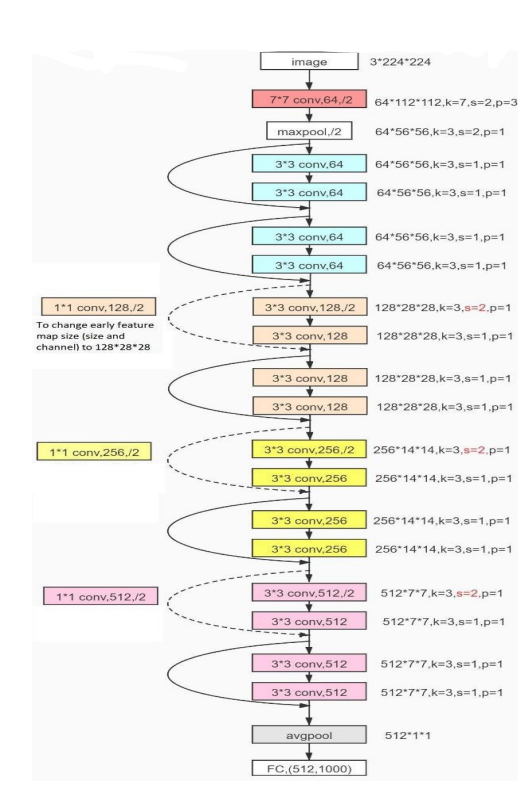

즉, 224*224가 아닌,

 우리의 이미지 크기 64*64가 ResNet으로 들어가 

 최종 layer에서 7*7의 차원을 갖도록 output size를 조절해가며 stride, padding 및 kernel size등을 조정해 보시면 됩니다.

**이 부분에 어떻게 stride, padding등을 바꿔서 최종 7*7을 만들었는지 서술 해 주세요**

After conv1 : 64 * 64 -> 32 * 32

After layer1 : 32 * 32 -> 32 * 32

After layer2 : 32 * 32 -> 16 * 16

After layer3 : 16 * 16 -> 16 * 16 (change stride into 1)

After layer4 : 16 * 16 -> 7 * 7 (change padding into 0)

## 2. 성능 높이기

Resnet의 layer4 부분까지 fine-tunning 해 주세요

여러 hyperparameter들은 자유롭게 변경해가며 본인만의 ResNet을 만들어 보세요

#**2. Experiment**

## Model A

Fine-tune the 'layer4' and Retrain 'fc'

In [2]:
## 필요한 모듈 import

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision 
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [ ]:
# Pre-trained ResNet 가져오기
Resnet = torchvision.models.resnet18(pretrained=True) # 해당 부분을 False로 바꾸면 구조만 가져온다

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# ResNet18의 layer이름을 확인 ( 이후 layer 고칠 때 찾기 쉬우라고 함 )
for name,child in Resnet.named_children(): 
  print('Layer Name : ',name) # 각 layer의 이름 확인
  print('Layer Info. : ',child) # 각 layer의 정보 확인
  print()

Layer Name :  conv1
Layer Info. :  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Layer Name :  bn1
Layer Info. :  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Layer Name :  relu
Layer Info. :  ReLU(inplace=True)

Layer Name :  maxpool
Layer Info. :  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

Layer Name :  layer1
Layer Info. :  Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps

In [3]:
## 데이터셋 로드 
from torchvision.datasets import ImageFolder
import os

data_dir = 'face_dataset'
path = {x: os.path.join('/content/drive/MyDrive/',data_dir,'facescrub_'+x) for x in ['train', 'test'] } # Train, Test 경로 지정
## local에 이미지를 저장했으면 저장한 경로만 찾아서 붙여넣어 주기
print(path)
train_data = ImageFolder(path['train'], transforms.Compose([transforms.ToTensor()]))

{'train': '/content/drive/MyDrive/face_dataset/facescrub_train', 'test': '/content/drive/MyDrive/face_dataset/facescrub_test'}


In [4]:
# Input Normalize 계산하는데 오래걸려서 미리 구해둠
avgR = 0.6565039 
avgG = 0.4843807
avgB = 0.4084822
stdR = 0.20245129
stdG = 0.17317267
stdB = 0.1622832

In [5]:
## 데이터 전처리를 위한 과정

data_transforms = {
    'facescrub_train': transforms.Compose([
        # 이미지 증강
        transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
        transforms.RandomVerticalFlip(), # 수직으로 뒤집기
        # 이미지를 텐서로 변경
        transforms.ToTensor(),
        # Input 값 Normalize 해주기 ( 각 채널의 평균 값과 표준편차 값으로 정규화 해줌 )
        transforms.Normalize([avgR, avgG, avgB], [stdR, stdG, stdB])
    ]),
    # 위와 동일한 과정 Test set에 대해 진행하기
    'facescrub_test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([avgR, avgG, avgB], [stdR, stdG, stdB])
    ]),
}

In [6]:
## 앞서 정의한 data_transforms를 이용해 실제 train과 test 이미지셋을 만들어 준다
image_datasets = {x: datasets.ImageFolder(os.path.join('/content/drive/MyDrive/face_dataset/', x),
                                          data_transforms[x]) for x in ['facescrub_train', 'facescrub_test']}

In [ ]:
## Train과 Testset의 크기 확인
data_sizes = {x: len(image_datasets[x]) for x in ['facescrub_train', 'facescrub_test']}
print(data_sizes['facescrub_train'])
print(data_sizes['facescrub_test'])

4000
1000


In [7]:
## Dataloader를 설정해 준다
dataloaders = {x: torch.utils.data.DataLoader(
                       image_datasets[x], batch_size=16, # 이 부분에서 batch_size를 설정할 수 있음 
                       shuffle=True, # train data를 batch로 묶을 때 섞을 것인지 결정
                       num_workers=2) # Dataloader가 data를 읽어들일 때 사용할 스레드의 개수 (GPU 사용량을 결정)
                                            for x in ['facescrub_train', 'facescrub_test']}
## class 이름 설정 
class_names = image_datasets['facescrub_train'].classes 

## 어떤 device를 이용할 것인지 결정한다 (gpu 불가능하면 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [43]:
## 세 전이학습에 사용할 ResNet 각각 load
## Resnet을 불러와 주세요
Resnet_sample = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# ResNet18의 layer이름을 확인 ( 이후 layer 고칠 때 찾기 쉬우라고 함 )
for name,child in Resnet.named_children(): 
  print('Layer Name : ',name) # 각 layer의 이름 확인
  print('Layer Info. : ',child) # 각 layer의 정보 확인
  print()

Layer Name :  conv1
Layer Info. :  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Layer Name :  bn1
Layer Info. :  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Layer Name :  relu
Layer Info. :  ReLU(inplace=True)

Layer Name :  maxpool
Layer Info. :  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

Layer Name :  layer1
Layer Info. :  Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps

In [ ]:
## Resnet의 output layer를 우리의 이미지에 맞도록 크기조정 해 주세요
## 단, kernel size를 바꿀 경우 가중치의 개수가 달라지므로 Fine-Tunning 시 해당 layer도 넣어서 해주셔야 합니다!
## stride를 조작해 보시는 것을 추천드립니다

In [44]:
## 해당 코드는 참조 코드입니다.
## 해당 cell을 실행시키면 Resnet 의 layer3의 conv1, downsample과 layer4의 conv1, downsample의 stride가 변경됩니다.
Resnet_sample.layer3[0].conv1.stride = (1, 1)
Resnet_sample.layer3[0].downsample[0].stride = (1, 1)
Resnet_sample.layer4[0].conv1.stride = (1, 1)
Resnet_sample.layer4[0].downsample[0].stride = (1, 1)

In [ ]:
# 변경된 정보를 확인해 보세요
for name,child in Resnet_sample.named_children(): 
  print('Layer Name : ',name) 
  print('Layer Info. : ',child) 
  print()

Layer Name :  conv1
Layer Info. :  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Layer Name :  bn1
Layer Info. :  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Layer Name :  relu
Layer Info. :  ReLU(inplace=True)

Layer Name :  maxpool
Layer Info. :  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

Layer Name :  layer1
Layer Info. :  Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps

In [ ]:
from torchsummary import summary as summary_

In [ ]:
summary_(Resnet_sample.cuda(),(3,64,64),batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 64, 32, 32]           9,408
       BatchNorm2d-2           [16, 64, 32, 32]             128
              ReLU-3           [16, 64, 32, 32]               0
         MaxPool2d-4           [16, 64, 16, 16]               0
            Conv2d-5           [16, 64, 16, 16]          36,864
       BatchNorm2d-6           [16, 64, 16, 16]             128
              ReLU-7           [16, 64, 16, 16]               0
            Conv2d-8           [16, 64, 16, 16]          36,864
       BatchNorm2d-9           [16, 64, 16, 16]             128
             ReLU-10           [16, 64, 16, 16]               0
       BasicBlock-11           [16, 64, 16, 16]               0
           Conv2d-12           [16, 64, 16, 16]          36,864
      BatchNorm2d-13           [16, 64, 16, 16]             128
             ReLU-14           [16, 64,

In [45]:
seq_train_loss = []
seq_test_loss = []
seq_train_acc = []
seq_test_acc = []

In [49]:
## Train 함수 정의

def train(model,epoch,optimizer,criterion,scheduler=None,save_every=None):
    ## 각 단계의 loss 및 accuracy 저장할 list 생성

    print(f'\n[ Train epoch: {epoch+1} ]')

    model.train() # Train 단계임을 선업

    running_loss = 0.0
    batch_losses = []
    total = 0
    correct = 0

    for batch_idx, (inputs, targets) in enumerate(dataloaders['facescrub_train']): # Train data 가져오기
        inputs, targets = inputs.to(device), targets.to(device) # dataloader의 input image와 label도 device에 넣어준다
        if len(optimizer) != 1:
          optimizer[0].zero_grad()
          optimizer[1].zero_grad()
        else:
          optimizer.zero_grad() # gradient 초기화
        outputs = model(inputs) # Prediction value 계산 (Output 계산)
        loss = criterion(outputs, targets) # outputs와 원래 label인 targets 사이 loss 계산
        loss.backward() # 계산한 loss 기반으로 gradient 값 계산
        if len(optimizer) != 1:
          optimizer[0].step() # weight parameter update
          optimizer[1].step()
        else:
          optimizer.step()
        if scheduler :
          scheduler.step()

        total += targets.size(0) # batch 데이터 개수 더하기
        running_loss += loss.item()
        batch_losses.append(loss.item())
        
        _, predicted = outputs.max(1) # 확률값 가장 높게 나타난 클래스
        correct += (predicted == targets).sum().item() # 현재 batch 내에서 알맞게 분류한 이미지 개수 더하기
        
        if batch_idx % 50 == 49:
            ## 학습 중간 성능 확인
            print(f'\nCurrent batch: {str(batch_idx+1)}')
            print(f'Average train loss of recent 50 batches: {running_loss / 49}') 
            running_loss = 0.0

    if save_every :
      if (epoch % save_every == 0): # 얼마만큼의 iteration마다 저장할 것인지를 설정
          directory = os.path.join(save_path, 'Resnet') # 경로 설정
          if not os.path.exists(directory): # 경로가 없다면 새로 만듦
              os.makedirs(directory)
          if len(optimizer) != 0:
            torch.save({ 
                # 학습 중간에 저장하려 하는 모든 것들을 dict로 서술
                'epoch': epoch, 
                'iteration': batch_idx,
                'model': model.state_dict(),
                'opt1': optimizer[0].state_dict(),
                'opt2': optimizer[1].state_dict(),
                'loss': loss
                #,'sch': scheduler.state_dict()
                }, os.path.join(directory, '{}ep_{}iter_{}_A.tar'.format(epoch,batch_idx,'checkpoint')))
          else:
            torch.save({ 
              # 학습 중간에 저장하려 하는 모든 것들을 dict로 서술
              'epoch': epoch, 
              'iteration': batch_idx,
              'model': model.state_dict(),
              'opt': optimizer.state_dict(),
              'loss': loss
              #,'sch': scheduler.state_dict()
              }, os.path.join(directory, '{}ep_{}iter_{}_A.tar'.format(epoch,batch_idx,'checkpoint')))

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_train_loss.append(avg_loss)
    seq_train_acc.append(100*correct/total)
    print('\nTotal train accuarcy:', 100. * correct / total) # 전체 데이터 개수에서 맞게 예측한 비율
    print('Total train loss:', avg_loss)

In [50]:
def test(model,epoch,criterion):
    print(f'\n[ Test epoch: {epoch+1} ]')

    model.eval() # Test time임을 선언

    loss = 0
    batch_losses = []
    correct = 0
    total = 0

    with torch.no_grad(): # gradient update 안함 - eval과 torch.no_grad는 하나의 세트
        for batch_idx, (inputs, targets) in enumerate(dataloaders['facescrub_test']):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            batch_losses.append(loss.item())

            total += targets.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_test_loss.append(avg_loss)
    seq_test_acc.append(100 * correct / total)
    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', avg_loss)

In [51]:
## fine-tunning 하고싶은 부분을 제외하고 update를 얼려 주세요
for name,child in Resnet_sample.named_children():
  for param in child.parameters():
    if name not in ['layer4','fc']:   
      param.requires_grad = False

In [ ]:
## 지정한 device에 학습시킬 모델 얹어주기
Resnet_sample.to(device)

In [53]:
## Optimizer, Scheduler, Cost Function 등을 직접 설정해서 사용해 보세요
optimizer_retrain = optim.SGD(params=Resnet_sample.fc.parameters(),lr=0.01)
optimizer_fine_tune = optim.SGD(params=Resnet_sample.layer4.parameters(),lr=0.001)
optimizer = [optimizer_retrain,optimizer_fine_tune]
scheduler = None
criterion = nn.CrossEntropyLoss()

In [17]:
num_epochs = 100

In [18]:
## Checkpoint를 저장할 경로를 설정해 주세요
save_path = '/content/drive/MyDrive/save/Resnet'

In [54]:
## 학습을 진행해 주세요 (GPU로 돌려야 합니다 CPU는 너무 느려요)
for epoch in range(0,num_epochs):
  train(Resnet_sample,epoch,optimizer,criterion,save_every=1)
  test(Resnet_sample,epoch,criterion)


[ Train epoch: 1 ]

Current batch: 50
Average train loss of recent 50 batches: 8.29768842580367

Current batch: 100
Average train loss of recent 50 batches: 6.827142764110954

Current batch: 150
Average train loss of recent 50 batches: 6.062027989601602

Current batch: 200
Average train loss of recent 50 batches: 5.554734171653281

Current batch: 250
Average train loss of recent 50 batches: 5.209664880012979

Total train accuarcy: 1.425
Total train loss: 6.262446613311767

[ Test epoch: 1 ]

Test accuarcy: 3.0
Test average loss: 5.175343884362115

[ Train epoch: 2 ]

Current batch: 50
Average train loss of recent 50 batches: 4.957234786481274

Current batch: 100
Average train loss of recent 50 batches: 4.852635476053978

Current batch: 150
Average train loss of recent 50 batches: 4.662583579822463

Current batch: 200
Average train loss of recent 50 batches: 4.529846673109094

Current batch: 250
Average train loss of recent 50 batches: 4.389808567202821

Total train accuarcy: 5.8
Total

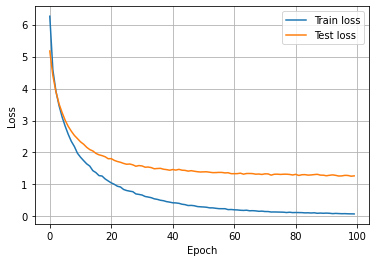

In [57]:
## 저장이 진행되었는지 확인해 보시고 성능 그래프를 그려주세요
plt.plot(range(num_epochs), seq_train_loss, label="Train loss")
plt.plot(range(num_epochs), seq_test_loss, label="Test loss")
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

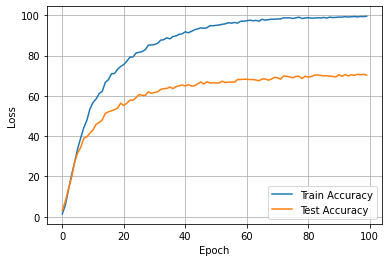

In [58]:
plt.plot(range(num_epochs), seq_train_acc, label="Train Accuracy")
plt.plot(range(num_epochs), seq_test_acc, label="Test Accuracy")
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

수고하셨습니다!

## Model B 

Fine-tune all 'layers' (1, 2, 3, 4) and Retrain 'fc' layer

In [8]:
Resnet_sample_B = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [9]:
Resnet_sample_B.layer3[0].conv1.stride = (1, 1)
Resnet_sample_B.layer3[0].downsample[0].stride = (1, 1)
Resnet_sample_B.layer4[0].conv1.stride = (1, 1)
Resnet_sample_B.layer4[0].downsample[0].stride = (1, 1)

In [10]:
seq_train_loss_B = []
seq_test_loss_B = []
seq_train_acc_B = []
seq_test_acc_B = []

In [11]:
## Train 함수 정의

def train(model,epoch,optimizer,criterion,scheduler=None,save_every=None):
    ## 각 단계의 loss 및 accuracy 저장할 list 생성

    print(f'\n[ Train epoch: {epoch+1} ]')

    model.train() # Train 단계임을 선업

    running_loss = 0.0
    batch_losses = []
    total = 0
    correct = 0

    for batch_idx, (inputs, targets) in enumerate(dataloaders['facescrub_train']): # Train data 가져오기
        inputs, targets = inputs.to(device), targets.to(device) # dataloader의 input image와 label도 device에 넣어준다
        if len(optimizer) != 1:
          optimizer[0].zero_grad()
          optimizer[1].zero_grad()
        else:
          optimizer.zero_grad() # gradient 초기화
        outputs = model(inputs) # Prediction value 계산 (Output 계산)
        loss = criterion(outputs, targets) # outputs와 원래 label인 targets 사이 loss 계산
        loss.backward() # 계산한 loss 기반으로 gradient 값 계산
        if len(optimizer) != 1:
          optimizer[0].step() # weight parameter update
          optimizer[1].step()
        else:
          optimizer.step()
        if scheduler :
          scheduler.step()

        total += targets.size(0) # batch 데이터 개수 더하기
        running_loss += loss.item()
        batch_losses.append(loss.item())
        
        _, predicted = outputs.max(1) # 확률값 가장 높게 나타난 클래스
        correct += (predicted == targets).sum().item() # 현재 batch 내에서 알맞게 분류한 이미지 개수 더하기
        
        if batch_idx % 50 == 49:
            ## 학습 중간 성능 확인
            print(f'\nCurrent batch: {str(batch_idx+1)}')
            print(f'Average train loss of recent 50 batches: {running_loss / 49}') 
            running_loss = 0.0

    if save_every :
      if (epoch % save_every == 0): # 얼마만큼의 iteration마다 저장할 것인지를 설정
          directory = os.path.join(save_path, 'Resnet') # 경로 설정
          if not os.path.exists(directory): # 경로가 없다면 새로 만듦
              os.makedirs(directory)
          if len(optimizer) != 0:
            torch.save({ 
                # 학습 중간에 저장하려 하는 모든 것들을 dict로 서술
                'epoch': epoch, 
                'iteration': batch_idx,
                'model': model.state_dict(),
                'opt1': optimizer[0].state_dict(),
                'opt2': optimizer[1].state_dict(),
                'loss': loss
                #,'sch': scheduler.state_dict()
                }, os.path.join(directory, '{}ep_{}iter_{}_B.tar'.format(epoch,batch_idx,'checkpoint')))
          else:
            torch.save({ 
              # 학습 중간에 저장하려 하는 모든 것들을 dict로 서술
              'epoch': epoch, 
              'iteration': batch_idx,
              'model': model.state_dict(),
              'opt': optimizer.state_dict(),
              'loss': loss
              #,'sch': scheduler.state_dict()
              }, os.path.join(directory, '{}ep_{}iter_{}_B.tar'.format(epoch,batch_idx,'checkpoint')))

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_train_loss_B.append(avg_loss)
    seq_train_acc_B.append(100*correct/total)
    print('\nTotal train accuarcy:', 100. * correct / total) # 전체 데이터 개수에서 맞게 예측한 비율
    print('Total train loss:', avg_loss)

In [12]:
def test(model,epoch,criterion):
    print(f'\n[ Test epoch: {epoch+1} ]')

    model.eval() # Test time임을 선언

    loss = 0
    batch_losses = []
    correct = 0
    total = 0

    with torch.no_grad(): # gradient update 안함 - eval과 torch.no_grad는 하나의 세트
        for batch_idx, (inputs, targets) in enumerate(dataloaders['facescrub_test']):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            batch_losses.append(loss.item())

            total += targets.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_test_loss_B.append(avg_loss)
    seq_test_acc_B.append(100 * correct / total)
    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', avg_loss)

In [13]:
## 모두 fine tunning or retrain 이므로 모두 update

In [ ]:
Resnet_sample_B.to(device)

In [15]:
optimizer_retrain = optim.SGD(params=Resnet_sample_B.fc.parameters(),lr=0.01)
params_ = [param for name,param in Resnet_sample_B.named_parameters() if name[:2] not in ['fc']]
optimizer_fine_tune = optim.SGD(params=params_,lr=0.001)
optimizer = [optimizer_retrain,optimizer_fine_tune]
scheduler = None
criterion = nn.CrossEntropyLoss()

In [19]:
for epoch in range(0,num_epochs):
  train(Resnet_sample_B,epoch,optimizer,criterion,save_every=1)
  test(Resnet_sample_B,epoch,criterion)


[ Train epoch: 1 ]

Current batch: 50
Average train loss of recent 50 batches: 8.272435869489398

Current batch: 100
Average train loss of recent 50 batches: 6.757249112031897

Current batch: 150
Average train loss of recent 50 batches: 5.787261573635802

Current batch: 200
Average train loss of recent 50 batches: 5.390563896724156

Current batch: 250
Average train loss of recent 50 batches: 5.080947311557069

Total train accuarcy: 2.075
Total train loss: 6.132537721633911

[ Test epoch: 1 ]

Test accuarcy: 4.6
Test average loss: 4.882463318961007

[ Train epoch: 2 ]

Current batch: 50
Average train loss of recent 50 batches: 4.6676963348777925

Current batch: 100
Average train loss of recent 50 batches: 4.410861647858912

Current batch: 150
Average train loss of recent 50 batches: 4.2617126386992785

Current batch: 200
Average train loss of recent 50 batches: 4.0904231266099575

Current batch: 250
Average train loss of recent 50 batches: 4.033430167606899

Total train accuarcy: 10.5


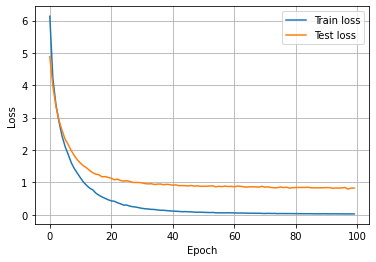

In [21]:
## 저장이 진행되었는지 확인해 보시고 성능 그래프를 그려주세요
plt.plot(range(num_epochs), seq_train_loss_B, label="Train loss")
plt.plot(range(num_epochs), seq_test_loss_B, label="Test loss")
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

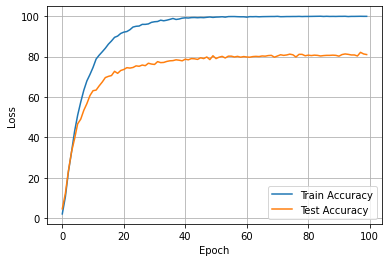

In [22]:
plt.plot(range(num_epochs), seq_train_acc_B, label="Train Accuracy")
plt.plot(range(num_epochs), seq_test_acc_B, label="Test Accuracy")
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Model C

Fine tune the 'layer1' and retrain 'fc'

In [23]:
Resnet_sample_C = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
Resnet_sample_C.layer3[0].conv1.stride = (1, 1)
Resnet_sample_C.layer3[0].downsample[0].stride = (1, 1)
Resnet_sample_C.layer4[0].conv1.stride = (1, 1)
Resnet_sample_C.layer4[0].downsample[0].stride = (1, 1)

In [25]:
seq_train_loss_C = []
seq_test_loss_C = []
seq_train_acc_C = []
seq_test_acc_C = []

In [26]:
## Train 함수 정의

def train(model,epoch,optimizer,criterion,scheduler=None,save_every=None):
    ## 각 단계의 loss 및 accuracy 저장할 list 생성

    print(f'\n[ Train epoch: {epoch+1} ]')

    model.train() # Train 단계임을 선업

    running_loss = 0.0
    batch_losses = []
    total = 0
    correct = 0

    for batch_idx, (inputs, targets) in enumerate(dataloaders['facescrub_train']): # Train data 가져오기
        inputs, targets = inputs.to(device), targets.to(device) # dataloader의 input image와 label도 device에 넣어준다
        if len(optimizer) != 1:
          optimizer[0].zero_grad()
          optimizer[1].zero_grad()
        else:
          optimizer.zero_grad() # gradient 초기화
        outputs = model(inputs) # Prediction value 계산 (Output 계산)
        loss = criterion(outputs, targets) # outputs와 원래 label인 targets 사이 loss 계산
        loss.backward() # 계산한 loss 기반으로 gradient 값 계산
        if len(optimizer) != 1:
          optimizer[0].step() # weight parameter update
          optimizer[1].step()
        else:
          optimizer.step()
        if scheduler :
          scheduler.step()

        total += targets.size(0) # batch 데이터 개수 더하기
        running_loss += loss.item()
        batch_losses.append(loss.item())
        
        _, predicted = outputs.max(1) # 확률값 가장 높게 나타난 클래스
        correct += (predicted == targets).sum().item() # 현재 batch 내에서 알맞게 분류한 이미지 개수 더하기
        
        if batch_idx % 50 == 49:
            ## 학습 중간 성능 확인
            print(f'\nCurrent batch: {str(batch_idx+1)}')
            print(f'Average train loss of recent 50 batches: {running_loss / 49}') 
            running_loss = 0.0

    if save_every :
      if (epoch % save_every == 0): # 얼마만큼의 iteration마다 저장할 것인지를 설정
          directory = os.path.join(save_path, 'Resnet') # 경로 설정
          if not os.path.exists(directory): # 경로가 없다면 새로 만듦
              os.makedirs(directory)
          if len(optimizer) != 0:
            torch.save({ 
                # 학습 중간에 저장하려 하는 모든 것들을 dict로 서술
                'epoch': epoch, 
                'iteration': batch_idx,
                'model': model.state_dict(),
                'opt1': optimizer[0].state_dict(),
                'opt2': optimizer[1].state_dict(),
                'loss': loss
                #,'sch': scheduler.state_dict()
                }, os.path.join(directory, '{}ep_{}iter_{}_C.tar'.format(epoch,batch_idx,'checkpoint')))
          else:
            torch.save({ 
              # 학습 중간에 저장하려 하는 모든 것들을 dict로 서술
              'epoch': epoch, 
              'iteration': batch_idx,
              'model': model.state_dict(),
              'opt': optimizer.state_dict(),
              'loss': loss
              #,'sch': scheduler.state_dict()
              }, os.path.join(directory, '{}ep_{}iter_{}_C.tar'.format(epoch,batch_idx,'checkpoint')))

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_train_loss_C.append(avg_loss)
    seq_train_acc_C.append(100*correct/total)
    print('\nTotal train accuarcy:', 100. * correct / total) # 전체 데이터 개수에서 맞게 예측한 비율
    print('Total train loss:', avg_loss)

In [27]:
def test(model,epoch,criterion):
    print(f'\n[ Test epoch: {epoch+1} ]')

    model.eval() # Test time임을 선언

    loss = 0
    batch_losses = []
    correct = 0
    total = 0

    with torch.no_grad(): # gradient update 안함 - eval과 torch.no_grad는 하나의 세트
        for batch_idx, (inputs, targets) in enumerate(dataloaders['facescrub_test']):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            batch_losses.append(loss.item())

            total += targets.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_test_loss_C.append(avg_loss)
    seq_test_acc_C.append(100 * correct / total)
    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', avg_loss)

In [ ]:
Resnet_sample_C.to(device)

In [37]:
optimizer_retrain = optim.SGD(params=Resnet_sample_C.fc.parameters(),lr=0.01)
optimizer_fine_tune = optim.SGD(params=Resnet_sample_C.layer1.parameters(),lr=0.001)
optimizer = [optimizer_retrain,optimizer_fine_tune]
scheduler = None
criterion = nn.CrossEntropyLoss()

In [39]:
for name,child in Resnet_sample_C.named_children():
  for param in child.parameters():
    if name not in ['layer1','fc']:   
      param.requires_grad = False

In [40]:
for epoch in range(0,num_epochs):
  train(Resnet_sample_C,epoch,optimizer,criterion,save_every=1)
  test(Resnet_sample_C,epoch,criterion)


[ Train epoch: 1 ]

Current batch: 50
Average train loss of recent 50 batches: 8.349650324607381

Current batch: 100
Average train loss of recent 50 batches: 7.007097575129295

Current batch: 150
Average train loss of recent 50 batches: 6.401594132793193

Current batch: 200
Average train loss of recent 50 batches: 5.9372418753954825

Current batch: 250
Average train loss of recent 50 batches: 5.863426490705841

Total train accuarcy: 0.95
Total train loss: 6.577566038131714

[ Test epoch: 1 ]

Test accuarcy: 1.5
Test average loss: 5.732856394752623

[ Train epoch: 2 ]

Current batch: 50
Average train loss of recent 50 batches: 5.540095348747409

Current batch: 100
Average train loss of recent 50 batches: 5.493256276967574

Current batch: 150
Average train loss of recent 50 batches: 5.3399315756194445

Current batch: 200
Average train loss of recent 50 batches: 5.284530756424885

Current batch: 250
Average train loss of recent 50 batches: 5.199864582139618

Total train accuarcy: 2.25
To

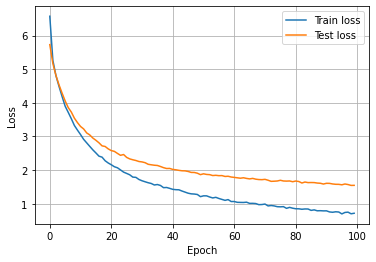

In [41]:
## 저장이 진행되었는지 확인해 보시고 성능 그래프를 그려주세요
plt.plot(range(num_epochs), seq_train_loss_C, label="Train loss")
plt.plot(range(num_epochs), seq_test_loss_C, label="Test loss")
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

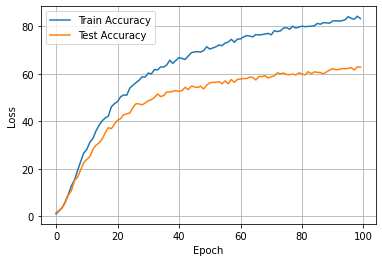

In [42]:
plt.plot(range(num_epochs), seq_train_acc_C, label="Train Accuracy")
plt.plot(range(num_epochs), seq_test_acc_C, label="Test Accuracy")
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#**3.  Results & Conclusion**

## Result Code

In [ ]:
plt.plot(range(num_epochs), seq_train_loss, label="Train loss", color='r')
plt.plot(range(num_epochs), seq_test_loss, label="Test loss", color='darkred')
plt.legend()
plt.title('Train & Test Loss for Model A')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(range(num_epochs), seq_train_acc, label="Train loss", color='r')
plt.plot(range(num_epochs), seq_test_acc, label="Test loss", color='darkred')
plt.legend()
plt.title('Train & Test Accuracy for Model A')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(range(num_epochs), seq_train_loss_B, label="Train loss B", color='b')
plt.plot(range(num_epochs), seq_test_loss_B, label="Test loss B", color='darkblue')
plt.legend()
plt.title('Train & Test Loss for Model B')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(range(num_epochs), seq_train_acc_B, label="Train loss B", color='b')
plt.plot(range(num_epochs), seq_test_acc_B, label="Test loss B", color='darkblue')
plt.legend()
plt.title('Train & Test Accuracy for Model B')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(range(num_epochs), seq_train_loss_C, label="Train loss", color='lightgreen')
plt.plot(range(num_epochs), seq_test_loss_C, label="Test loss",color='darkgreen')
plt.legend()
plt.title('Train & Test Loss for Model C')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(range(num_epochs), seq_train_acc_C, label="Train loss C", color='lightgreen')
plt.plot(range(num_epochs), seq_test_acc_C, label="Test loss C", color='darkgreen')
plt.legend()
plt.title('Train & Test Accuracy for Model C')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(range(num_epochs), seq_train_loss, label="Train loss A", color='r')
plt.plot(range(num_epochs), seq_train_loss_B, label="Train loss B", color='g')
plt.plot(range(num_epochs), seq_train_loss_C, label="Train loss C", color='b')
plt.legend()
plt.title('Train Loss of Models')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(range(num_epochs), seq_test_loss, label="Test loss A", color='r')
plt.plot(range(num_epochs), seq_test_loss_B, label="Test loss B", color='g')
plt.plot(range(num_epochs), seq_test_loss_C, label="Test loss C", color='b')
plt.legend()
plt.title('Test Loss of Models')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(range(num_epochs), seq_train_acc, label="Train Accuracy A",color='r')
plt.plot(range(num_epochs), seq_train_acc_B, label="Train Accuracy B",color='g')
plt.plot(range(num_epochs), seq_train_acc_C, label="Train Accuracy C",color='b')
plt.legend()
plt.title('Train Accuracy of Models')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(range(num_epochs), seq_test_acc, label="Test Accuracy A",color='r')
plt.plot(range(num_epochs), seq_test_acc_B, label="Test Accuracy B",color='g')
plt.plot(range(num_epochs), seq_test_acc_C, label="Test Accuracy C",color='b')
plt.legend()
plt.title('Test Accuracy of Models')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Result & Conclusion



---



 결과적으로 Model B의 성능이 가장 좋았음.

 이는 이론적으로 설명하였던 (Based on Similarity Matrix) 내용과 잘 부합함.

 사람 얼굴에 대한 데이터는 general image와 유사도 자체는 낮지만, 데이터셋이 증강까지 더해져 충분했으므로 Matrix 상 1사분면에 위치한다고 할 수 있음.

해당 영역에서는 데이터가 충분하므로 과적합에 대한 걱정 없이 fc layer에 대하여 (비선형 분류기) Retrain을 진행할 수 있고, 모델 전체를 fine-tune 하여 우리의 이미지의 특성을 더 잘 추출하도록 할 수 있음. 

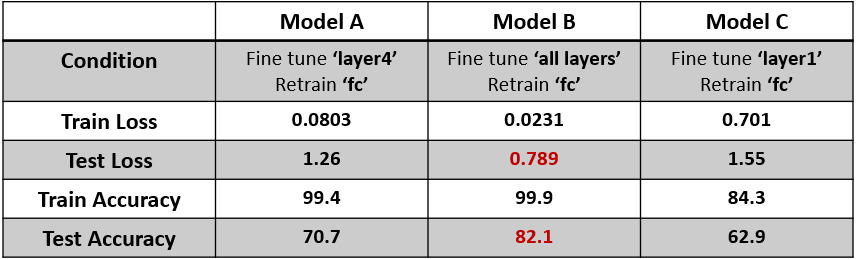

Table1. Summary of Experiment resluts and conditions

learning rate 는 모두 **fine tune 0.001**, **retrain 0.01**로 고정함.

Optimizer 는 **mini-batch SGD**로 고정하였고

epoch 은 **100** 으로 사용하였음

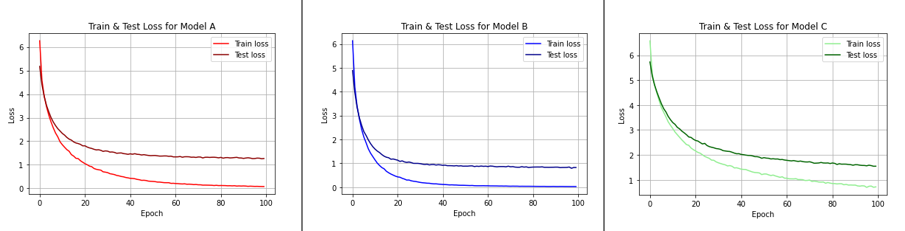

Fig1. Train and Test loss for each model

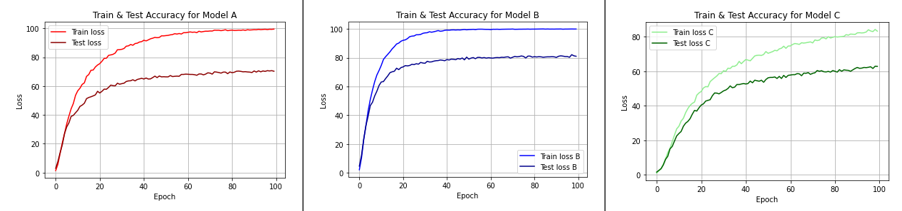

Fig2. Train and Test Accuracy for each model

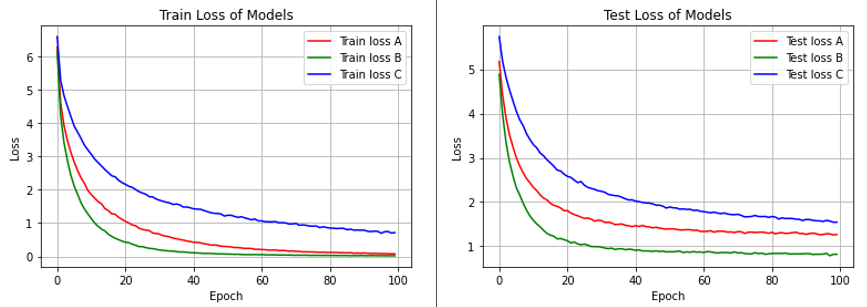

Fig3. Train and Test loss of each model

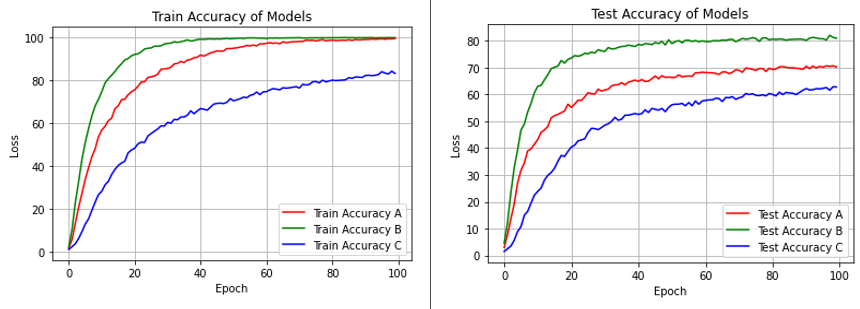

Fig4. Train and Test Accuracy of each model

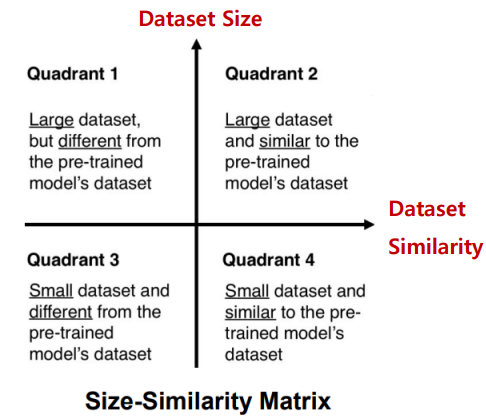

Fig5. Size-Similarity Matrix

Model A의 경우 layer4와 fc layer를 각각 fine tune, retrain 하였음.  

layer4를 fine tune 하는 것은 receptive field가 넓어진 상태의 neuron들에 대해 조정을 진행한다는 것임.

즉, 데이터의 유사성이 기본적으로 높을 때, 낮은 단계에서 추출하는 특성은 동일하지만 receptive field가 넓어진 상태에서는 pre-train 시 사용된 이미지와 다르니 해당 부분만 세부적으로 조정을 진행한다는 것.

결과적으로 성능이 그다지 좋지 않음. 이는 학습 시 사용된 데이터와 현재 사용한 데이터 간의 유사도가 높지 않았기 때문으로 생각됨. 유사도가 높지 않은 상태에서 이미지의 전체적인 모습만을 조정하고 초기에 추출되는 특성은 그대로 두었기 때문에 비약적인 성능의 개선은 없었음. 

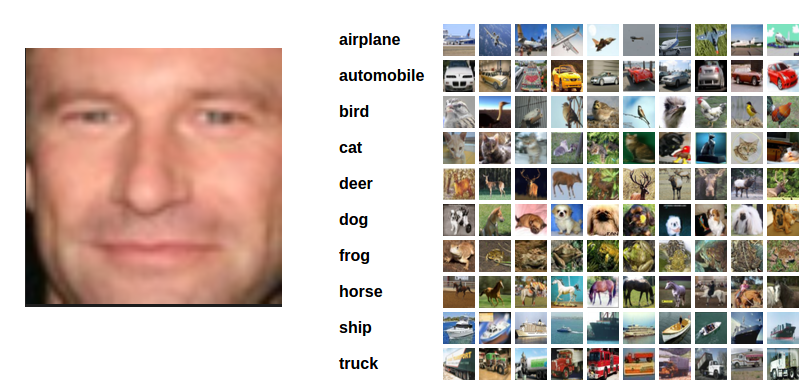

Fig6. Dataset we used for present task (left side) and pre-training (right side) 

Model C 는 초기의 특성추출 값만을 세부조정한 모델임. 

예상대로 유사도가 낮은 상태에서 receptive field가 큰 부분을 다시 조정하지 않고 초기 특성추출만을 고려하였기에 성능이 낮음.



가벼운 실험을 통해 전이학습에 대한 간단한 insight를 얻을 수 있었음.

**데이터셋에 대한 유사도가 낮을 때는, 전체적인 layer의 parameter에 대해서 fine tunning을 진행하고, classifier인 fc layer부분은 retrain 하는 것이 성능을 높이는 방법임.**

추가적으로 learning rate 를 fine tunning, retrain 부분에서 어떻게 가져갈 것인지는 생각해 볼 필요 있음. 또한, 데이터를 더욱 늘린 상태에서 과적합에 대한 고민 없이 classifier인 fc layer부분을 늘려보면 어떠한 결과가 나올지도 생각해 볼만 함. 